# Info

This notebook is designed to perform portoflio optimization using **Polici Gradient** reinforcement learnign algorithm.

Main paper used as guidance [A Deep Reinforcement Learning Framework for the
Financial Portfolio Management Problem](https://arxiv.org/pdf/1706.10059.pdf)

## Describe Finance Environment

* Always start with the closing price `v` and calculating the **price relative vector** as `v[t]/v[t-1]` .
* Define a `state` / `observation` as being the **vector price** as `yt = [1, v['stock_1'][t] / v['stock_2'][t-1], ..] ` along with the current assigned portfolio weights `w[t-1]`.
* Define an action as the values assigned for `w[t]` of values between `0-1` that sum up to `1`.
* Define the reward in two ways:
    * Average Portfolio logarithmic rate of return `r[t] = np.log(y[t] * w[t-1])`.
    * Sharpe ratio using portfolio logarithmic rate of return.


## Notations and Formulas:

`p0` - Initial investment amount.

`m` - Number of assets in portfolio.

`w` - Portfolio weights(vector of sum 1). Represents how much does each asset count.

`v` - Asset closing prices (list).

`v[t]` - Asset closing price at time `t`

`y` - Price relative vector(matrix).

`y[t]` - Price relative vector at time `t` that start with cash value of `1`.

`p` - Portfolio value(list). Is calculated as the **dot product** between `y` and `w`. 

`r` - Logarithmic rate of return. 

`avg_r` -  Avergae logarithmic cumulated return. Is basically the average of the logarithmic return.

`sharpe_ratio` - Average(`r`) / Standard Deviation(`r`).



## Sharpe Ratio

The Sharpe ratio is a commonly used indicator to measure the risk adjusted performance of an investment over time. Assuming a risk-free rate of 0, the formula for computing Sharpe ratio is simply the mean returns of the investment divided by the standard deviation of the returns. This can be written as:

$S _T = {A \over \sqrt{B - A^2}}$

where $A={1\over T}\sum\limits _{t=1}^{T}R _t$, and $B={1\over T}\sum\limits _{t=1}^{T}R _t^2$



# Imports

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython import display
import torch
import matplotlib.dates as mdates

%matplotlib inline
plt.style.use('ggplot')
torch.manual_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__, device

('1.4.0', device(type='cpu'))

# Read Data

In [3]:
# read stock data
stock_df = pd.read_csv("../../data/sample_stocks.csv")

# convert 'Date' to datetime
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

# set as index 'Date' columns
stock_df = stock_df.set_index('Date')

# show head
stock_df.head(10)

,DIS,AAPL,JNJ,PG,APD,XOM,MSFT,CAT,ADM,WMT
Date,,,,,,,,,,
1993-01-11,9.719281,1.909367,6.144024,6.266618,10.060392,6.590362,1.782007,2.174250,6.936274,9.709465
1993-01-12,9.690695,1.831206,6.160454,6.282525,9.873097,6.535896,1.794505,2.145705,7.064129,9.791740
1993-01-13,9.890798,1.890757,6.144024,6.362051,9.766070,6.563130,1.824496,2.163329,7.255918,9.832889
1993-01-14,10.176661,1.935421,6.078311,6.425670,9.712554,6.576745,1.824496,2.158468,7.319841,9.915166
1993-01-15,10.262424,1.793986,6.160454,6.524821,9.926609,6.549514,1.794505,2.207082,7.223950,9.956310
1993-01-18,10.205246,1.771654,6.144024,6.444863,9.899851,6.467812,1.784507,2.202221,7.223950,9.853454
1993-01-19,10.148077,1.779099,5.963319,6.364897,9.766070,6.413347,1.767011,2.197359,7.032168,9.812319
1993-01-20,10.176661,1.786543,6.012602,6.332913,9.632290,6.372497,1.767011,2.177914,7.000203,9.832889
1993-01-21,10.291001,1.786543,6.045456,6.332913,9.632290,6.331647,1.789505,2.119577,7.128061,9.791740


# Sample Example

Math formulas sanity checks.

# Same weights

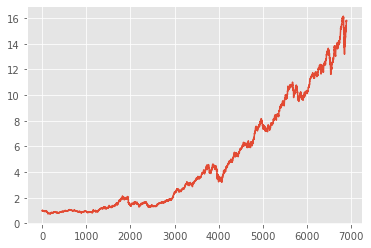

15.799927600344615


In [4]:
# initial investment
p0 = 1
# intial weights - fixed for this example
w = np.array([0.2, 0.3, 0.5])
# start with fewer stocks
ret_data = stock_df[['DIS', 'AAPL']].copy(deep=True)
# length of data
T = len(ret_data)
# add cash values 
ret_data['CASH'] = np.ones(T)
# convert to numpy for easy computation
ret_data = ret_data.to_numpy()
# calculate price vector
y = ret_data[1:T] / ret_data[0:T-1]
# weighted return
r = np.dot(y, w)
# plot cumulative weighted return
plt.plot(np.cumprod(r))
plt.show()
# final portfolio value
pf = p0*np.exp(np.sum(np.log(r)))
print(pf)

# Equal Weights

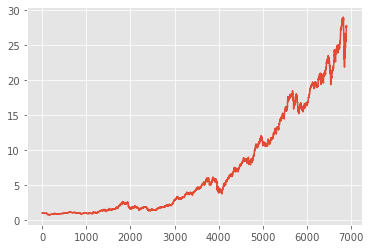

27.740783335359666


In [4]:
# initial investment
p0 = 1
# intial weights - fixed for this example
# w = np.array([0.2, 0.3, 0.5])
w = np.array([1/3]*3)
# start with fewer stocks
ret_data = stock_df[['DIS', 'AAPL']].copy(deep=True)
# length of data
T = len(ret_data)
# add cash values 
ret_data['CASH'] = np.ones(T)
# convert to numpy for easy computation
ret_data = ret_data.to_numpy()
# calculate price vector
y = ret_data[1:T] / ret_data[0:T-1]
# weighted return
r = np.dot(y, w)
# plot cumulative weighted return
plt.plot(np.cumprod(r))
plt.show()
# final portfolio value
pf = p0*np.exp(np.sum(np.log(r)))
print(pf)

# Random Weights

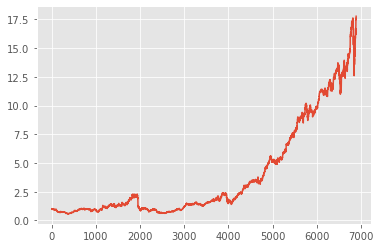

17.772327664198578


In [5]:
# initial investment
p0 = 1
# start with fewer stocks
ret_data = stock_df[['DIS', 'AAPL']].copy(deep=True)
# length of data
T = len(ret_data)
# add cash values 
ret_data['CASH'] = np.ones(T)
# convert to numpy for easy computation
ret_data = ret_data.to_numpy()
# calculate price vector
y = ret_data[1:T] / ret_data[0:T-1]
# intial weights - fixed for this example
w = np.random.dirichlet(np.ones(3),size=len(y))
# weighted return
r = np.sum((y*w), axis=1)
# r = np.dot(y, w)
# plot cumulative weighted return
plt.plot(np.cumprod(r))
plt.show()
# final portfolio value
pf = p0*np.exp(np.sum(np.log(r)))
print(pf)

# Price Vector

In [6]:
# portfolio assets
assets = ['DIS', 'AAPL']#['DIS', 'AAPL', 'JNJ', 'PG', 'APD', 'XOM', 'MSFT', 'CAT', 'ADM', 'WMT']

# number of assets + cash
m = len(assets) + 1

# length of data
t = len(stock_df)

# numpy data
stock_np = stock_df[assets].to_numpy()

# cash column
cash_column = np.ones((1,t)).T

# add cash column
stock_np = np.concatenate((cash_column, stock_np), axis=1)

# calculate price vector
y = stock_np[1:t] / stock_np[0:t-1]

# set first row to 1
y[0] = np.ones(m)

y[:10]

array([[1.        , 1.        , 1.        ],
       [1.        , 1.02064896, 1.03251997],
       [1.        , 1.02890191, 1.02362262],
       [1.        , 1.00842742, 0.92692276],
       [1.        , 0.99442846, 0.9875519 ],
       [1.        , 0.99439808, 1.00420174],
       [1.        , 1.00281664, 1.00418422],
       [1.        , 1.01123559, 1.        ],
       [1.        , 0.98333401, 0.99166649],
       [1.        , 0.98022553, 1.00840354]])

# Split Price Vector in Train-Test

In [7]:
# use for traiding
n_trade = 1800

# used for training
train_data = y[:-n_trade]
# used for trading
test_data = y[-n_trade:]

# keep track of dates for plot purposes
dates = [stock_df[1:-n_trade].index[0], stock_df[-n_trade:].index[0]]

print("Train data:", train_data.shape)
print("Test data: ", test_data.shape)

Train data: (5095, 3)
Test data:  (1800, 3)


# PyTorch Model

In [8]:
class PortfolioModel(torch.nn.Module):
    def __init__(self, input_dim, n_assets, lr=0.3):
        super(PortfolioModel, self).__init__()
        self.theta = torch.nn.Linear(in_features=input_dim, out_features=n_assets, bias=False)
        self.potfolio_weights = torch.nn.Softmax(dim=1)
        
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=0.0)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, observation):
        state = torch.Tensor(observation).to(self.device)
        logits = self.theta(state)
        weights = self.potfolio_weights(logits)
        return weights
    

def portfolio_weights(torch_model, normalized_data, number_assets):
    """Get agents predicted portofolio weights for each time step
    """
    # number of examples in data
    n_examples = len(normalized_data)
    # initialize portfolio weights
    portfolio_weights = np.zeros((n_examples, number_assets))
    # intialize first weights
    portfolio_weights[0][0] = 1.
    # get all predicted weights
    with torch.no_grad():
        for i in range(n_examples-1):
            # get input
            input_sequence = np.concatenate((normalized_data[i], portfolio_weights[i]), axis=0)
            # update weights for next time-step
            portfolio_weights[i+1] = model(np.expand_dims(input_sequence, axis=0))
    
    return portfolio_weights


def mean_return_loss(model_output, train_data, device='cpu'):
    """Agent reward as calculated in the paper
    """
    # move data to tensor
    tensor_data = torch.tensor(train_data, dtype=torch.float32, device=device)
    # perform dot product
    # element wise multiplication
    weighted_return = torch.mul(tensor_data, model_output)
    # sum on row axis
    weighted_return = torch.sum(weighted_return, dim=1)
    # final reward is sum of all rewards
    # negative sign is for gradient ascent training
    loss = -1. * torch.sum(torch.log(weighted_return))
    # return mean of weighted return with negative sign
    # return list of weighted returns
    return loss, weighted_return.detach().numpy()


def train(torch_model, train_data, test_data, epochs=1, evaluate_step=2, device='cpu'):
    number_assets = len(train_data[0])
    train_loss = []
    # baseline model - keep same weights
    base_w = np.array([1/number_assets]*number_assets)
    base_return = np.sum((test_data*base_w), axis=1)
    for epoch in range(epochs):
        # forward pass to get portfolio weights
        w = portfolio_weights(torch_model, train_data, number_assets)
        # get train data
        forward_data = np.concatenate((train_data, w), axis=1)
        # move tensor to device
        forward_data = torch.tensor(forward_data, dtype=torch.float32, device=device)
        # set model for training
        torch_model.train()
        # reset optimizer
        torch_model.optimizer.zero_grad()
        # forward pass
        outputs = torch_model(forward_data)
        # get loss as portfolio return
        loss, weighted_returns = mean_return_loss(outputs, train_data, device=device)
        # backward pass
        loss.backward()
        # optimize step
        torch_model.optimizer.step()
        # keep track of loss (sharpe ratio)
        # remember this was negative so need to make it positive again
        train_loss.append(-loss.item())
        
        # verbose
        if epoch % evaluate_step == 0 or (epoch == (epochs-1)):
            # forward pass to get portfolio weights
            test_w = portfolio_weights(torch_model, test_data, number_assets)
            # weighted return
            test_weighted_returns = np.sum((test_data*test_w), axis=1)
            # display evaluation steps
            display.clear_output(wait=True)
            plt.plot(np.cumprod(test_weighted_returns), label="RL Optimization", linewidth=1)
            plt.plot(np.cumprod(base_return), label="Same Weights", linewidth=1)
            plt.title("Epoch %d/%d"%(epoch, epochs))
            plt.legend()
            print("weights: ", test_w)
            display.display(plt.show())
    
    return weighted_returns

# Train

Note: 
* No need to standardize data?
* it looks like it's not training..

weights:  [[1.         0.         0.        ]
 [0.15449794 0.21031621 0.63518578]
 [0.13433141 0.17144799 0.6942206 ]
 ...
 [0.13470101 0.16914947 0.69614947]
 [0.13587937 0.17022809 0.69389254]
 [0.13488737 0.169294   0.6958186 ]]


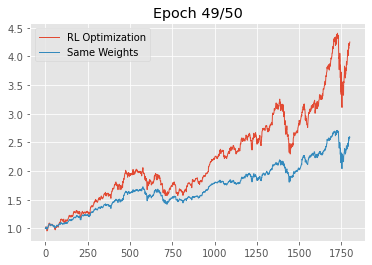

None

In [9]:
# standardize data
std = np.std(train_data)
mean = np.mean(train_data)

y_train = (train_data - mean) / std
y_test = (test_data - mean) / std


input_dim = m*2

# build portfolio optimization model
model = PortfolioModel(input_dim=input_dim, n_assets=m, lr=0.01)

rt = train(torch_model=model, train_data=train_data, test_data=test_data, epochs=50, evaluate_step=2)